# DeepFool Adversarial Attack
[DeepFool: a simple and accurate method to fool deep neural networks](https://arxiv.org/pdf/1511.04599.pdf)

[Medium blog about DeepFool](https://towardsdatascience.com/deepfool-a-simple-and-accurate-method-to-fool-deep-neural-networks-17e0d0910ac0)

[LTS4 DeepFool implementation](https://github.com/LTS4/DeepFool/tree/master/Python)

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
import math
import torchvision.models as models
from PIL import Image
import os
import copy

### DeepFool Algorithm

<img src="https://miro.medium.com/max/1400/1*IgCRmdFMEMt8vyGzxMsq9A.png" width="400"/>


In [0]:
def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=50):

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
    is_cuda = torch.cuda.is_available()

    if is_cuda:
        print("Using GPU")
        image = image.cuda()
        net = net.cuda()
    else:
        print("Using CPU")


    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
        fs = net.forward(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

In [0]:
def clip_tensor(A, minv, maxv):
        A = torch.max(A, minv*torch.ones(A.shape))
        A = torch.min(A, maxv*torch.ones(A.shape))
        return A

def test_deepfool(net, image, mean, std):
    im = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean,
                            std = std)])(image)

    r, loop_i, label_orig, label_pert, pert_image = deepfool(im, net)

    labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')

    str_label_orig = ' '.join(labels[np.int(label_orig)].split(',')[0].split(' ')[1:])
    str_label_pert = ' '.join(labels[np.int(label_pert)].split(',')[0].split(' ')[1:])

    print("Original label = ", str_label_orig)
    print("Perturbed label = ", str_label_pert)

    clip = lambda x: clip_tensor(x, 0, 255)

    tf = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=list(map(lambda x: 1 / x, std))),
                            transforms.Normalize(mean=list(map(lambda x: -x, mean)), std=[1, 1, 1]),
                            transforms.Lambda(clip),
                            transforms.ToPILImage(),
                            transforms.CenterCrop(224)])

    original_image = tf(im)
    perturbed_image = tf(pert_image.cpu()[0])
    minimal_perturbation = r.squeeze().transpose(1,2,0)

    fig=plt.figure(figsize=(15, 15))
    columns = 4
    rows = 5
    fig.add_subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original\n' + str_label_orig)
    fig.add_subplot(1, 3, 2)
    plt.imshow(perturbed_image)
    plt.title('Perturbed\n' + str_label_pert)
    fig.add_subplot(1, 3, 3)
    plt.imshow(minimal_perturbation)
    plt.title("Minimal perturbation")

    plt.show()

In [0]:
net = models.resnet34(pretrained=True)

# Switch to evaluation mode
net.eval()

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]

### Example images test


Using GPU


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original label =  macaw
Perturbed label =  flamingo


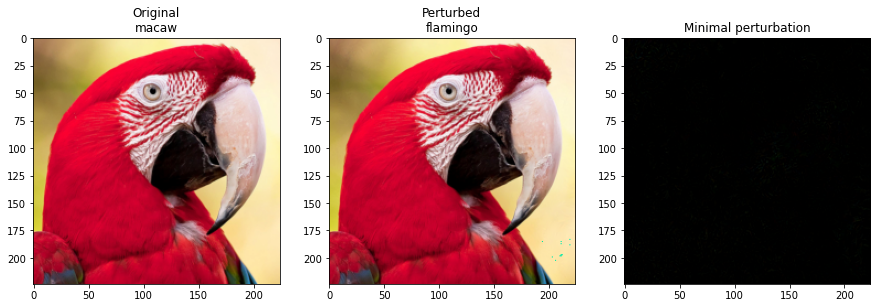

In [96]:
im1 = Image.open('test_im1.jpg')
test_deepfool(net,im1,mean,std)

Using GPU


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original label =  horse cart
Perturbed label =  Arabian camel


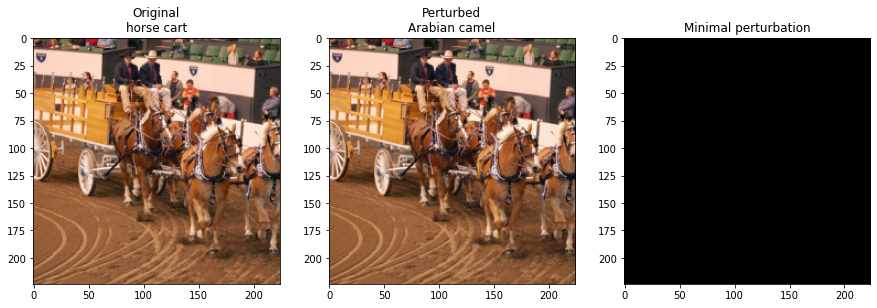

In [97]:
im2 = Image.open('test_im2.jpg')
test_deepfool(net,im2,mean,std)

Using GPU


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original label =  grey whale
Perturbed label =  komondor


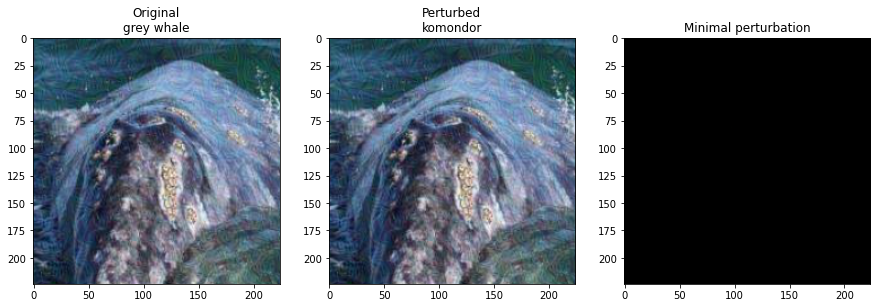

In [98]:
im3 = Image.open('test_im3.jpg')
test_deepfool(net,im3,mean,std)

Using GPU


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original label =  dalmatian
Perturbed label =  Great Dane


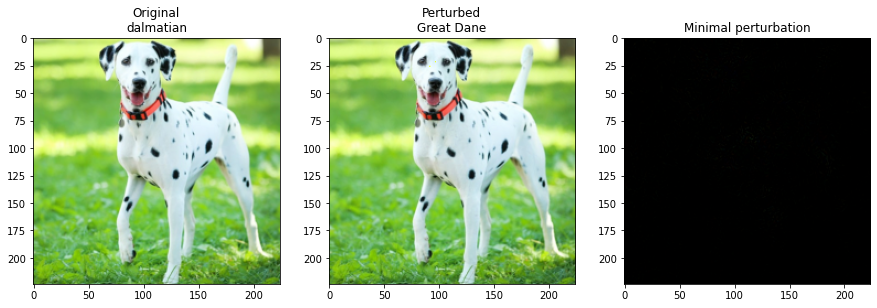

In [99]:
im4 = Image.open('test_im4.jpg')
test_deepfool(net,im4,mean,std)